<img src="../images/BDG_LOGO.png" alt="drawing" align="right" width="200"/>

# H2020 RIA BigDataGrapes - Predictive Data Analytics (T4.3)

## Farm Management Pilot

### This pilot is described in the deliverable D4.3 (Pilot 3).

The specific goal of the price prediction is is to develop a machine-learning component that performs water balance prediction using meteorological data from weather stations and soil data.

In [2]:
!pip install --user pandas scikit-learn rankeval

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, max_error, make_scorer
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt

import pickle
import rankeval

# Load the "Il Palazzo" dataset

## Load the features

In [22]:
df_feature = pd.read_csv("./data/palazzo/ilpalazzo2019_features.csv", header=None, sep=';', decimal=',')
df_feature = df_feature.drop(columns=0)
df_feature = df_feature.apply(pd.to_numeric, errors='coerce', )

X_ilpalazzo = df_feature.values
X_ilpalazzo

array([[12.12, 18.89,  4.81, ..., 13.8 , 13.4 ,  3.3 ],
       [12.46, 20.77,  6.12, ..., 13.8 , 13.6 ,  2.4 ],
       [12.3 , 21.03,  3.29, ..., 13.9 , 13.6 ,  2.9 ],
       ...,
       [12.42, 20.59,  6.58, ..., 17.6 , 17.3 ,  1.  ],
       [14.04, 18.99, 10.5 , ..., 17.4 , 17.2 ,  0.7 ],
       [14.92, 18.94, 12.85, ..., 17.4 , 17.2 ,  0.7 ]])

## Load the labels and normalize them

In [23]:
df_label = pd.read_csv("./data/palazzo/ilpalazzo2019_label.csv", header=None, sep=';', usecols=[2])

y_ilpalazzo = df_label.values.ravel()

scaler_ilpalazzo = MinMaxScaler()
y_ilpalazzo = scaler_ilpalazzo.fit_transform(y_ilpalazzo[:, np.newaxis]).ravel()

## Plot the distributions of the normalized labels

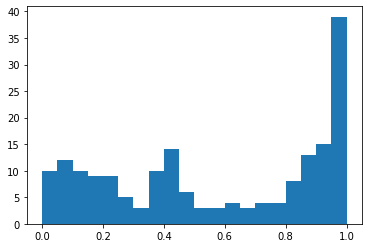

In [24]:
plt.hist(y_ilpalazzo, bins=20)
plt.show()

# Load the "Casato Prime Donne" dataset

## Load the features

In [25]:
df_feature = pd.read_csv("./data/casatoprimedonne/casatoprimedonne2019_features.csv", header=None, sep=';', decimal=',')
df_feature = df_feature.drop(columns=0)
df_feature = df_feature.apply(pd.to_numeric, errors='coerce', )

X_casato = df_feature.values
X_casato

array([[11.51, 19.5 ,  3.64, ..., 14.1 , 13.5 ,  2.9 ],
       [12.85, 21.39,  7.03, ..., 13.9 , 13.6 ,  3.1 ],
       [12.42, 21.26,  3.63, ..., 14.1 , 13.7 ,  4.1 ],
       ...,
       [14.87, 20.96,  9.95, ..., 18.9 , 18.6 ,  1.6 ],
       [13.52, 22.32,  7.06, ..., 18.8 , 18.5 ,  1.6 ],
       [13.81, 22.26,  6.82, ..., 18.5 , 18.2 ,  1.4 ]])

## Load the labels and normalize them

In [26]:
df_label = pd.read_csv("./data/casatoprimedonne/casatoprimedonne2019_label.csv", header=None, sep=';', usecols=[1])

y_casato = df_label.values.ravel()

scaler_casato = MinMaxScaler()
y_casato = scaler_casato.fit_transform(y_casato[:, np.newaxis]).ravel()

## Plot the distributions of the normalized labels

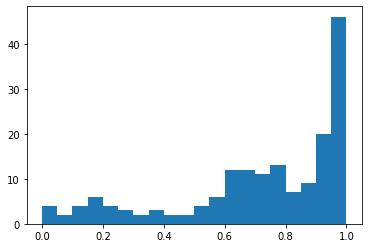

In [27]:
plt.hist(y_casato, bins=20)
plt.show()

# Concatenate the two datasets and shuffle them

In [28]:
X = np.concatenate((X_casato, X_ilpalazzo))
y = np.concatenate((y_casato, y_ilpalazzo))

reordered_rows = np.random.permutation(np.arange(X.shape[0]))
X = X[reordered_rows]
y = y[reordered_rows]

# Train/Test Split

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# Performs the Cross Validation of several learning models

In [30]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge, Lasso, LinearRegression, BayesianRidge
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, VotingRegressor, GradientBoostingRegressor

estimators = [
    LinearRegression(), 
    Ridge(), 
    Lasso(), 
    BayesianRidge(), 
    SVR(degree=1, gamma='scale'), 
    RandomForestRegressor(n_estimators=500), 
    GradientBoostingRegressor(n_estimators=500, validation_fraction=0.16),
]
estimators.append(VotingRegressor(estimators=[(est.__class__.__name__, est) for est in estimators]))

data = []
for clf in estimators:

    # neg_mean_squared_error_scorer = make_scorer(mean_squared_error, greater_is_better=False)

    scores = cross_val_score(clf, X, y, cv=5, scoring='neg_mean_squared_error')
    scores = np.sqrt(scores * -1)
    data.append((clf.__class__.__name__, scores.mean(), scores.std() * 2))
    print(f"{clf.__class__.__name__} - RMSE: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

LinearRegression - RMSE: 0.23 (+/- 0.21)
Ridge - RMSE: 0.22 (+/- 0.21)
Lasso - RMSE: 0.26 (+/- 0.03)
BayesianRidge - RMSE: 0.20 (+/- 0.21)
SVR - RMSE: 0.12 (+/- 0.03)
RandomForestRegressor - RMSE: 0.09 (+/- 0.03)
GradientBoostingRegressor - RMSE: 0.09 (+/- 0.02)
VotingRegressor - RMSE: 0.14 (+/- 0.08)


## Add a Neural Network model to the comparison

In [31]:
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler

std_scale = StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

clf = MLPRegressor(solver='adam', alpha=1e-5, activation='relu', batch_size=50, max_iter=1000, validation_fraction=0.16,
                   hidden_layer_sizes=(50, 25, 1), random_state=1)

scores = cross_val_score(clf, X_scaled, y, cv=5, scoring='neg_mean_squared_error')
scores = np.sqrt(scores * -1)
data.append((clf.__class__.__name__, scores.mean(), scores.std() * 2))
print("RMSE: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

RMSE: 0.13 (+/- 0.07)


# Print the final result in a tabular view (sort ascending by RMSE)

In [32]:
df = pd.DataFrame(data=data, columns=["Model", "RMSE", "STD DEV"])
df = df.sort_values(by="RMSE", ascending=True)
df

,Model,RMSE,STD DEV
6,GradientBoostingRegressor,0.092149,0.021161
5,RandomForestRegressor,0.093598,0.027035
4,SVR,0.118373,0.027233
8,MLPRegressor,0.125809,0.069285
7,VotingRegressor,0.135782,0.076322
3,BayesianRidge,0.204234,0.206265
1,Ridge,0.217434,0.206341
0,LinearRegression,0.227946,0.212838
2,Lasso,0.261325,0.025370


# Train a model on the full dataset for usage within the API

In [39]:
clf = RandomForestRegressor(n_estimators=500)

clf.fit(
    X, 
    y
)

with open("./RandomForest.pkl", 'wb') as fp:
    pickle.dump(clf, fp)

# Compute Feature Importance on the Training Set

In [42]:
feature_names = np.array([
    "HC Air Temperature [°C] (avg)",
    "HC Air Temperature [°C] (max)",
    "HC Air Temperature [°C] (min)",
    
    "Precipitation [mm] (sum)",
    
    "Leaf Temperature (IR) [°C] (avg)",
    "Leaf Temperature (IR) [°C] (max)",
    "Leaf Temperature (IR) [°C] (min)",
    
    "Leaf Temperature (IR) [°C] (avg)",
    "Leaf Temperature (IR) [°C] (max)",
    "Leaf Temperature (IR) [°C] (min)",
    
    "EAG Soil Moisture [%] (0 cm)",
    "EAG Soil Moisture [%] (10 cm)",
    "EAG Soil Moisture [%] (20 cm)",
    "EAG Soil Moisture [%] (30 cm)",
    "EAG Soil Moisture [%] (40 cm)",
    "EAG Soil Moisture [%] (50 cm)",
    
    "Soil Temperature [°C]  0 cm (avg)",
    "Soil Temperature [°C]  0 cm (max)",
    "Soil Temperature [°C]  0 cm (min)",
    
    "Soil Temperature [°C]  10 cm (avg)",
    "Soil Temperature [°C]  10 cm (max)",
    "Soil Temperature [°C]  10 cm (min)",
    
    "Soil Temperature [°C]  20 cm (avg)",
    "Soil Temperature [°C]  20 cm (max)",
    "Soil Temperature [°C]  20 cm (min)",
    
    "Soil Temperature [°C]  30 cm (avg)",
    "Soil Temperature [°C]  30 cm (max)",
    "Soil Temperature [°C]  30 cm (min)",
    
    "Soil Temperature [°C]  40 cm (avg)",
    "Soil Temperature [°C]  40 cm (max)",
    "Soil Temperature [°C]  40 cm (min)",
    
    "Soil Temperature [°C]  50 cm (avg)",
    "Soil Temperature [°C]  50 cm (max)",
    "Soil Temperature [°C]  50 cm (min)",
    
    "Daily ET0 [mm]"
])

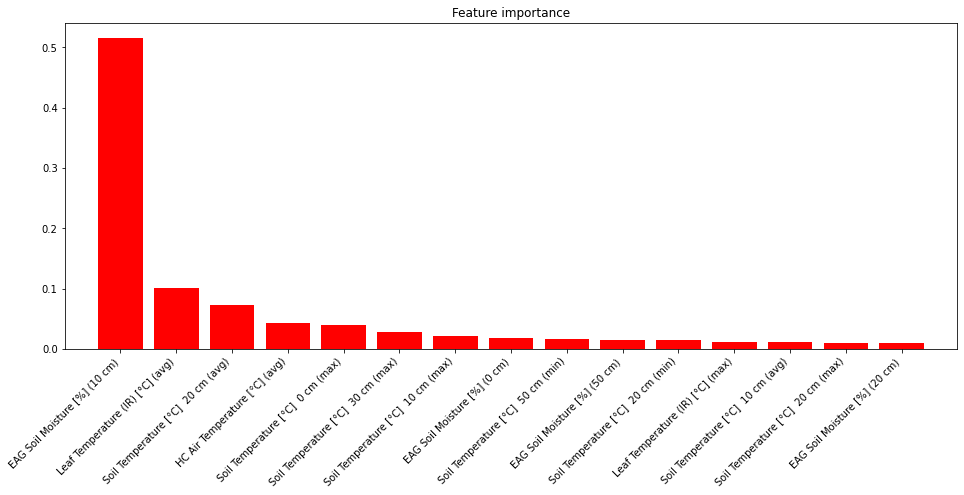

In [43]:
importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]

indices = indices[:15]

# Plot the impurity-based feature importances of the forest
plt.figure(figsize=(16,6))
plt.title("Feature importance")
plt.bar(np.arange(indices.size), importances[indices], color="red", align="center")
plt.xticks(np.arange(indices.size), feature_names[indices],  rotation=45, ha='right')
plt.xlim([-1, indices.size])
plt.show()